# <font color='blue'>1. User Details</font>

Name: Pravat Ranjan Pasayat

Master in Big Data and Business Analyitcs

IE University

May 2019

# <font color='blue'>2. Context</font>

Bike sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back to another position. Currently, there are about over 500 bike-sharing programs around the world which are composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real-world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system in Washington, DC with the corresponding weather and seasonal information.

# <font color='blue'>3. Content</font>

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv.

1. instant: Record index
2. dteday: Date
3. season: Season (1:springer, 2:summer, 3:fall, 4:winter)
4. yr: Year (0: 2011, 1:2012)
5. mnth: Month (1 to 12)
6. hr: Hour (0 to 23)
7. holiday: weather day is holiday or not (extracted from Holiday Schedule)
8. weekday: Day of the week
9. workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
10. weathersit: (extracted from Freemeteo)     
    a: Clear, Few clouds, Partly cloudy, Partly cloudy         
    b: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist         
    c: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds         
    d: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog      
11. temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
12. atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
13. hum: Normalized humidity. The values are divided to 100 (max)
14. windspeed: Normalized wind speed. The values are divided to 67 (max)
15. casual: count of casual users
16. registered: count of registered users
17. cnt: count of total rental bikes including both casual and registered

# <font color='blue'>4. Load necessary libraries</font>

This section is only dedicated to load necessary Python library that are used later in the course of this task.

In [1]:
import numpy as np

from scipy.stats.stats import pearsonr
from math import sqrt
from scipy import stats

import dask.dataframe as dd
import dask.array as da
from dask_ml.datasets import make_regression
from dask_ml.preprocessing import DummyEncoder
from dask_ml.linear_model import LinearRegression
from dask_ml.xgboost import XGBRegressor
from dask.distributed import Client

from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.externals.joblib import parallel_backend
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Supress warnings
warnings.filterwarnings("ignore")

# <font color='blue'>5. Read data</font>

1. The TRAIN and TEST data are both present in the file 'hour.csv'. 
2. The test set is the last quarter of the year 2012.
3. The rest of the data will be used for training.

In [2]:
# Load the data from a remote location to your working directory

!curl -O "https://raw.githubusercontent.com/pasayatpravat/Data_files/master/Bike_Sharing/hour.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2 1112k    2 31928    0     0  75658      0  0:00:15 --:--:--  0:00:15 75658
100 1112k  100 1112k    0     0  1827k      0 --:--:-- --:--:-- --:--:-- 1827k


In [3]:
# Load data
dataset_ddf = dd.read_csv("hour.csv")

# Set index
dataset_ddf = dataset_ddf.set_index("instant")

# Create 10 partitions of the dataframe
dataset_ddf = dataset_ddf.repartition(npartitions=5)

## Check partitions

In [4]:
# Check the number of partitions
print("Number of Partitions: ", dataset_ddf.npartitions)

# Check how the indexes are distributed over the partitions
print("Distribution of indexes across Partitions: ", dataset_ddf.divisions)

Number of Partitions:  5
Distribution of indexes across Partitions:  (1, 3476, 6952, 10427, 13903, 17379)


# <font color='blue'>6. Restructuring our dataset</font>

In this section, we will restructure or correct some of the discrepancies that we see in the data.
Some of things that needs to be corrected are:

1. Renaming column to give a more logical name
2. Converting date related fields from String to Date
3. Converting features that are categorical, but are incorrectly labeled as Numeric.
4. Remove unnecessary columns

In [5]:
# Rename columns
dataset_ddf = dataset_ddf.rename(
    columns={
        "dteday": "date",
        "mnth": "month",
        "yr": "year",
        "hr": "hour",
        "weathersit": "weather",
        "cnt": "count",
    }
)

# Datatype object to date
dataset_ddf["date"] = dd.to_datetime(dataset_ddf.date)

# Datatype numerical to Categorical
for i in [
    "month",
    "year",
    "hour",
    "season",
    "holiday",
    "weekday",
    "weather",
    "workingday",
]:
    dataset_ddf[i] = dataset_ddf[i].astype("category")
    
# Remove columns
dataset_ddf = dataset_ddf.drop(["casual", "registered"], axis=1)

# <font color='blue'>7. View Data </font>

In [6]:
# Check datatypes
print("Column Datatypes: \n", dataset_ddf.dtypes)

# See data
dataset_ddf.head()

Column Datatypes: 
 date          datetime64[ns]
season              category
year                category
month               category
hour                category
holiday             category
weekday             category
workingday          category
weather             category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
count                  int64
dtype: object


,date,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,count
instant,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [7]:
# Summary of the dataset
dataset_ddf.describe().compute().round(2)

,temp,atemp,hum,windspeed,count
count,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.50,0.48,0.63,0.19,189.46
std,0.19,0.17,0.19,0.12,181.39
min,0.02,0.00,0.00,0.00,1.00
25%,0.34,0.33,0.52,0.13,68.75
50%,0.60,0.55,0.66,0.22,205.00
75%,0.74,0.68,0.80,0.30,395.00
max,1.00,1.00,1.00,0.85,977.00


# <font color='blue'>8. Check missing values </font>

We should check if our dataset contains any missing values. So before building any predictive model, we have to clean our data by filling in all NA's or empty values with more appropriate values.

Let's analyze the NAs and empty/incorrect values present in various features.

In [8]:
# Check null values
print(
    "Is there any Missing values = " + str(dataset_ddf.isnull().values.any().compute()),
    "\n",
)

# Check null values per column
print(
    "Number of Missing values per column: \n\n ", dataset_ddf.isnull().sum().compute()
)

Is there any Missing values = False 

Number of Missing values per column: 

  date          0
season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
hum           0
windspeed     0
count         0
dtype: int64


# <font color='blue'>9. Check skewness </font>

We now need to detect skewness in different features. 

While building predictive models we often see skewness in the several numerical/integer variable. Then we generally take transformations to make it more normal. We generally do it for linear models and not for tree based models, but we will follow this process irrespectively of the model used to have a standard pipeline. This actually means that our distribution of variables are not normal, we are deliberately making it normal for prediction.

For numeric feature with excessive skewness, we perform different type of skewness transformation.

In [9]:
# Find out the numeric columns
numeric_columns = dataset_ddf._get_numeric_data().columns

# Check skewness on numeric features
dataset_ddf[numeric_columns].compute().skew()

temp        -0.006021
atemp       -0.090429
hum         -0.111287
windspeed    0.574905
count        1.277412
dtype: float64

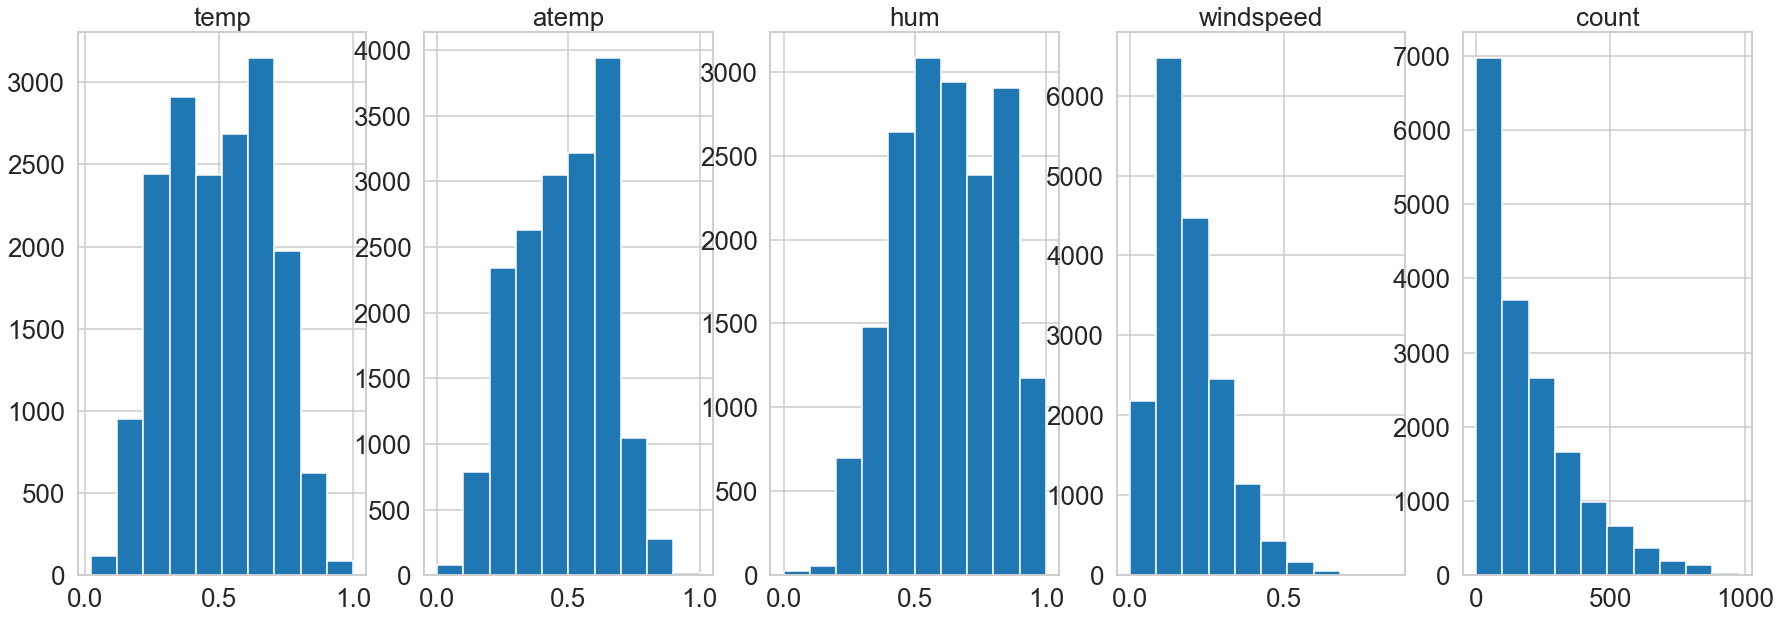

In [10]:
# Configuring plotting visual and sizes
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
plt.rcParams.update(params)

counter = 1
for i in numeric_columns.values:
    plt.subplot(1, len(numeric_columns), counter)
    plt.hist(dataset_ddf[i].compute())
    plt.title(str(i))
    counter += 1

1. **temp, atemp and humidity is almost symmetric. No actions needed**
2. **Windspeed and count is positive/right skewed. (square root, cube root, and log. transformation)**

In [11]:
# Handle Skewness

print("Skewness in count field after transformation: ", np.sqrt(dataset_ddf["count"]).compute().skew())
print("Skewness in windspeed field after transformation: ", np.log(dataset_ddf["windspeed"] + 1).compute().skew()) 

dataset_ddf["count"] = np.sqrt(dataset_ddf["count"])
dataset_ddf["windspeed"] = np.log(dataset_ddf["windspeed"] + 1)

Skewness in count field after transformation:  0.2864746130055621
Skewness in windspeed field after transformation:  0.2639259184381608


# <font color='blue'>10. Check correlation between features </font>

Here we will try to find 
1. The correlation of different features with Target variable.
2. The inter-correlation within different features.

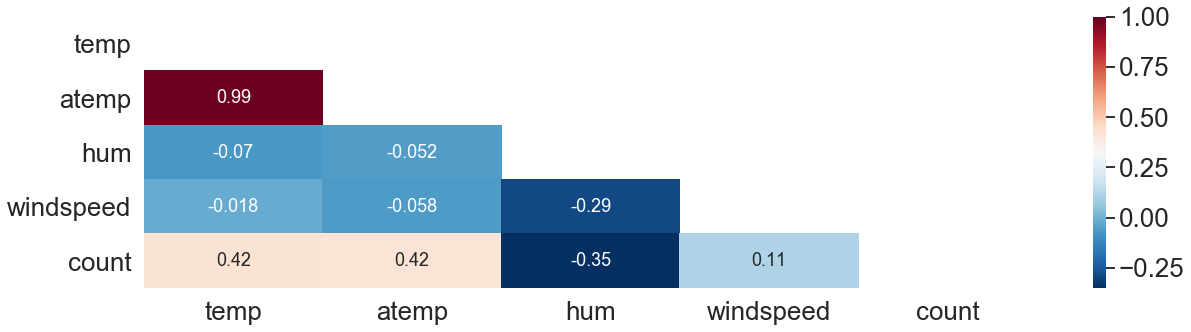

In [12]:
# Plot the correlation matrix

plt.figure(figsize=(20, 5))
mask = np.zeros_like(dataset_ddf.compute().corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_ddf.compute().corr(), cmap="RdBu_r", mask=mask, annot=True)

**We can see that temp and atemp are very correlated!! We should only keep one.**

**Let's analyze 'temp' and 'atemp', and decide which one to keep.**

In [13]:
print(pearsonr(dataset_ddf["temp"], dataset_ddf["count"]))
print(pearsonr(dataset_ddf["atemp"], dataset_ddf["count"]))

# Remove atemp
dataset_ddf = dataset_ddf.drop("atemp", 1)

(0.42077427695773295, 0.0)
(0.41722797925740523, 0.0)


# <font color='blue'>11. Visualize Data </font>

[Text(0.5, 1.0, 'Monthly distribution of bike renting')]

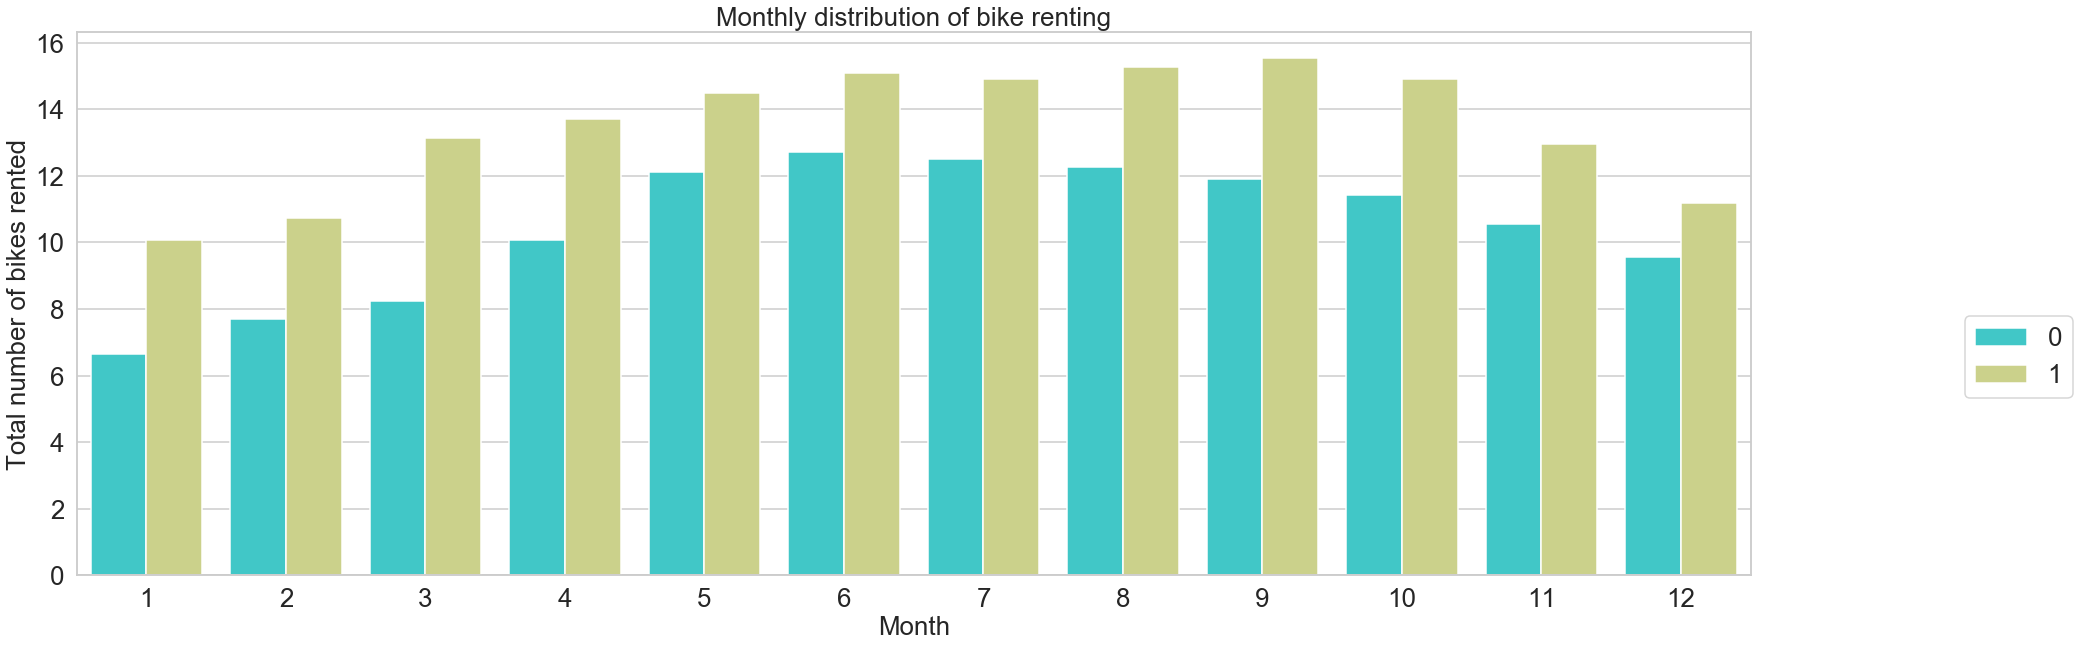

In [14]:
fig, ax = plt.subplots()
sns.barplot(
    "month",
    "count",
    hue="year",
    data=dataset_ddf[["month", "count", "year"]].compute(),
    palette="rainbow",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Month")
plt.ylabel("Total number of bikes rented")
ax.set(title="Monthly distribution of bike renting")

[Text(0.5, 1.0, 'Seasonal distribution of bike renting')]

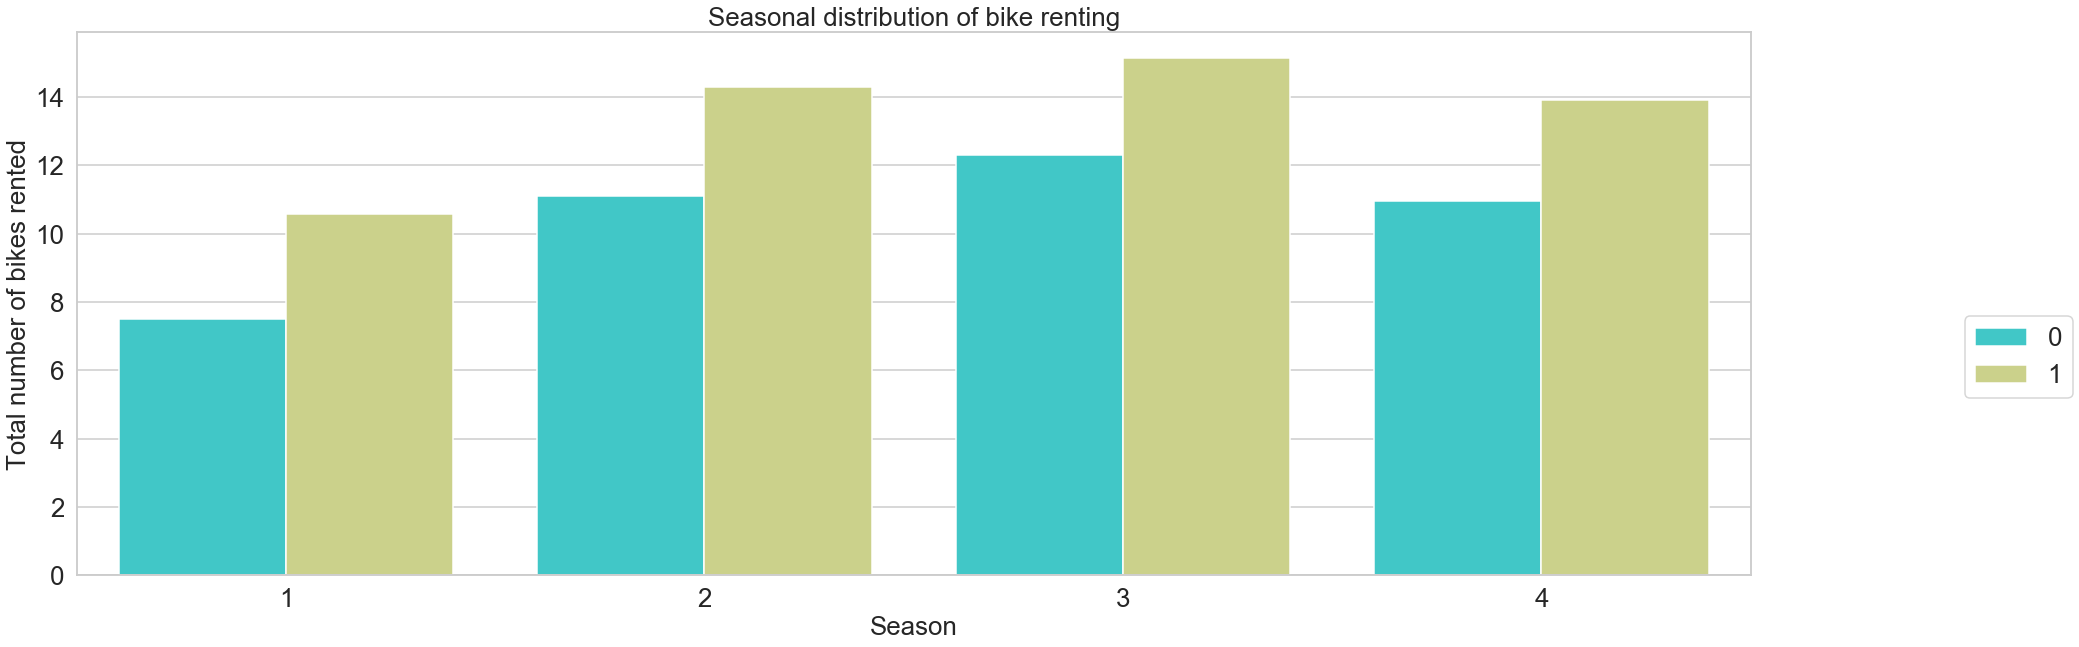

In [15]:
fig, ax = plt.subplots()
sns.barplot(
    "season",
    "count",
    hue="year",
    data=dataset_ddf[["season", "count", "year"]].compute(),
    palette="rainbow",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Season")
plt.ylabel("Total number of bikes rented")
ax.set(title="Seasonal distribution of bike renting")

[Text(0.5, 1.0, 'Weekly distribution of bike renting')]

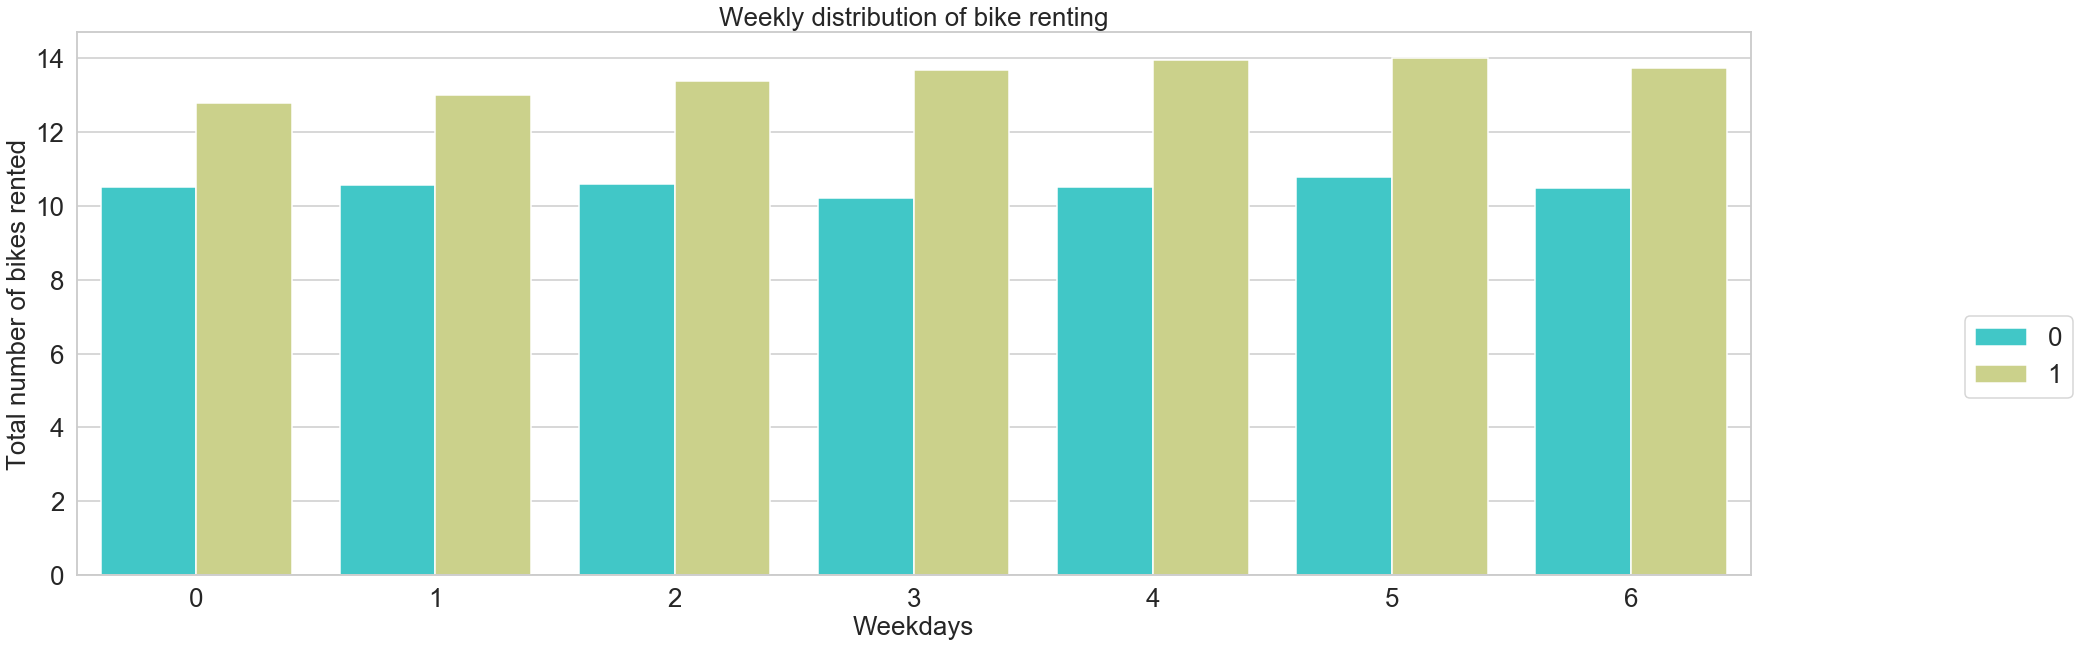

In [16]:
fig, ax = plt.subplots()
sns.barplot("weekday", "count", hue="year", data=dataset_ddf[["weekday", "count", "year"]].compute(), palette="rainbow", ci=None)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Weekdays")
plt.ylabel("Total number of bikes rented")
ax.set(title="Weekly distribution of bike renting")

[Text(0.5, 1.0, 'Bike renting in Holidays and non-holidays')]

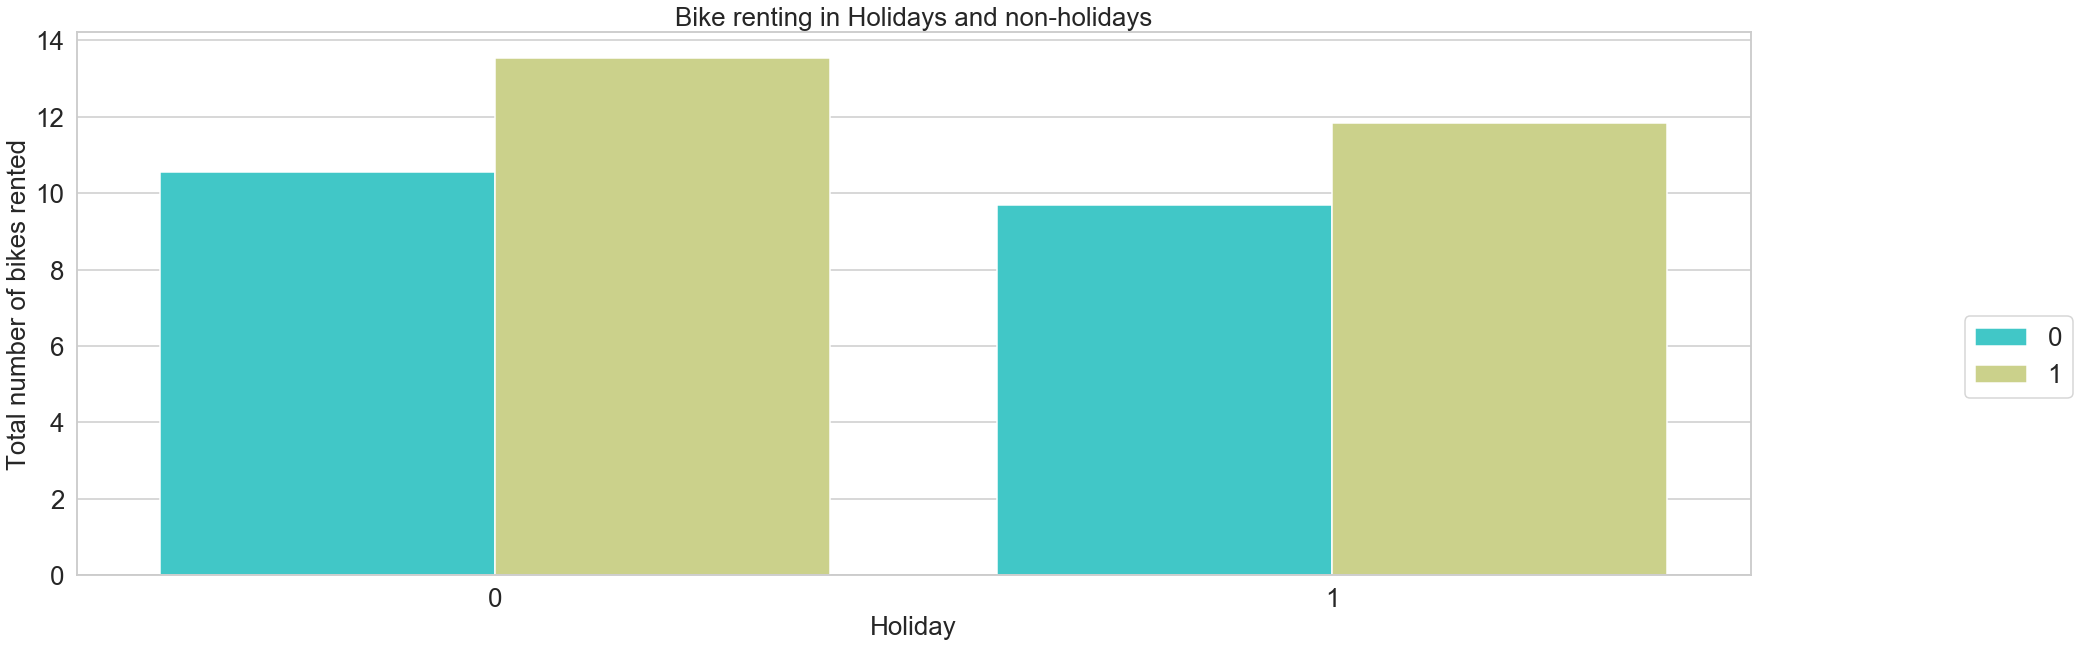

In [17]:
fig, ax = plt.subplots()
sns.barplot(
    "holiday",
    "count",
    hue="year",
    data=dataset_ddf[["holiday", "count", "year"]].compute(),
    palette="rainbow",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Holiday")
plt.ylabel("Total number of bikes rented")
ax.set(title="Bike renting in Holidays and non-holidays")

[Text(0.5, 1.0, 'Bike renting in Working days and non-working days')]

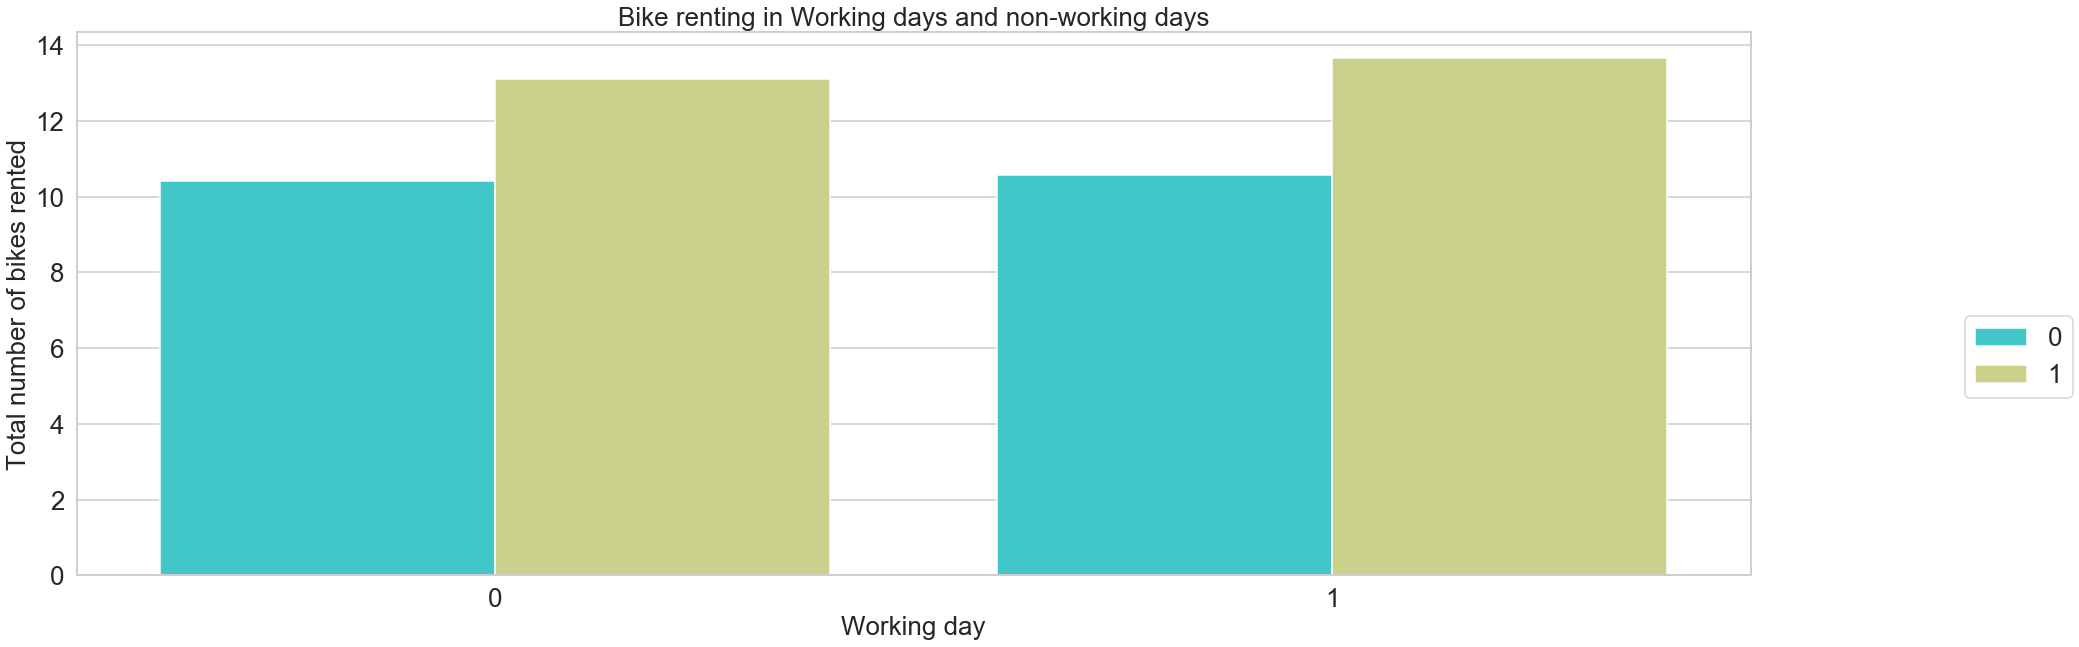

In [18]:
fig, ax = plt.subplots()
sns.barplot(
    "workingday",
    "count",
    hue="year",
    data=dataset_ddf[["workingday", "count", "year"]].compute(),
    palette="rainbow",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Working day")
plt.ylabel("Total number of bikes rented")
ax.set(title="Bike renting in Working days and non-working days")

[Text(0.5, 1.0, 'Bike renting in different Weather conditions')]

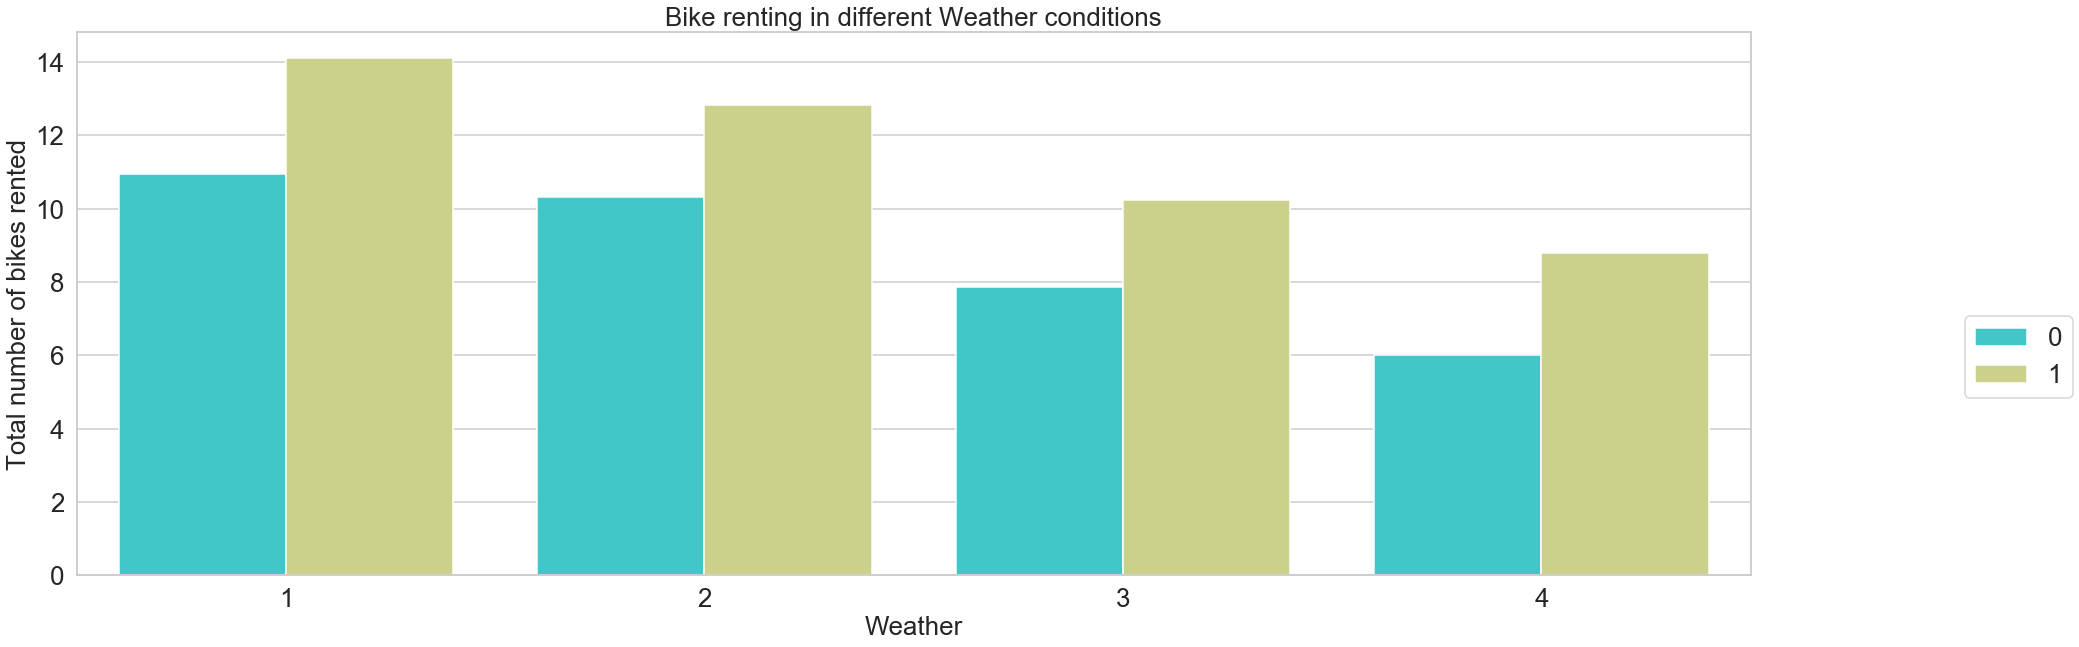

In [19]:
fig, ax = plt.subplots()
sns.barplot(
    "weather",
    "count",
    hue="year",
    data=dataset_ddf[["weather", "count", "year"]].compute(),
    palette="rainbow",
    ci=None,
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Weather")
plt.ylabel("Total number of bikes rented")
ax.set(title="Bike renting in different Weather conditions")

[Text(0.5, 1.0, 'Hourly distribution bike renting by years')]

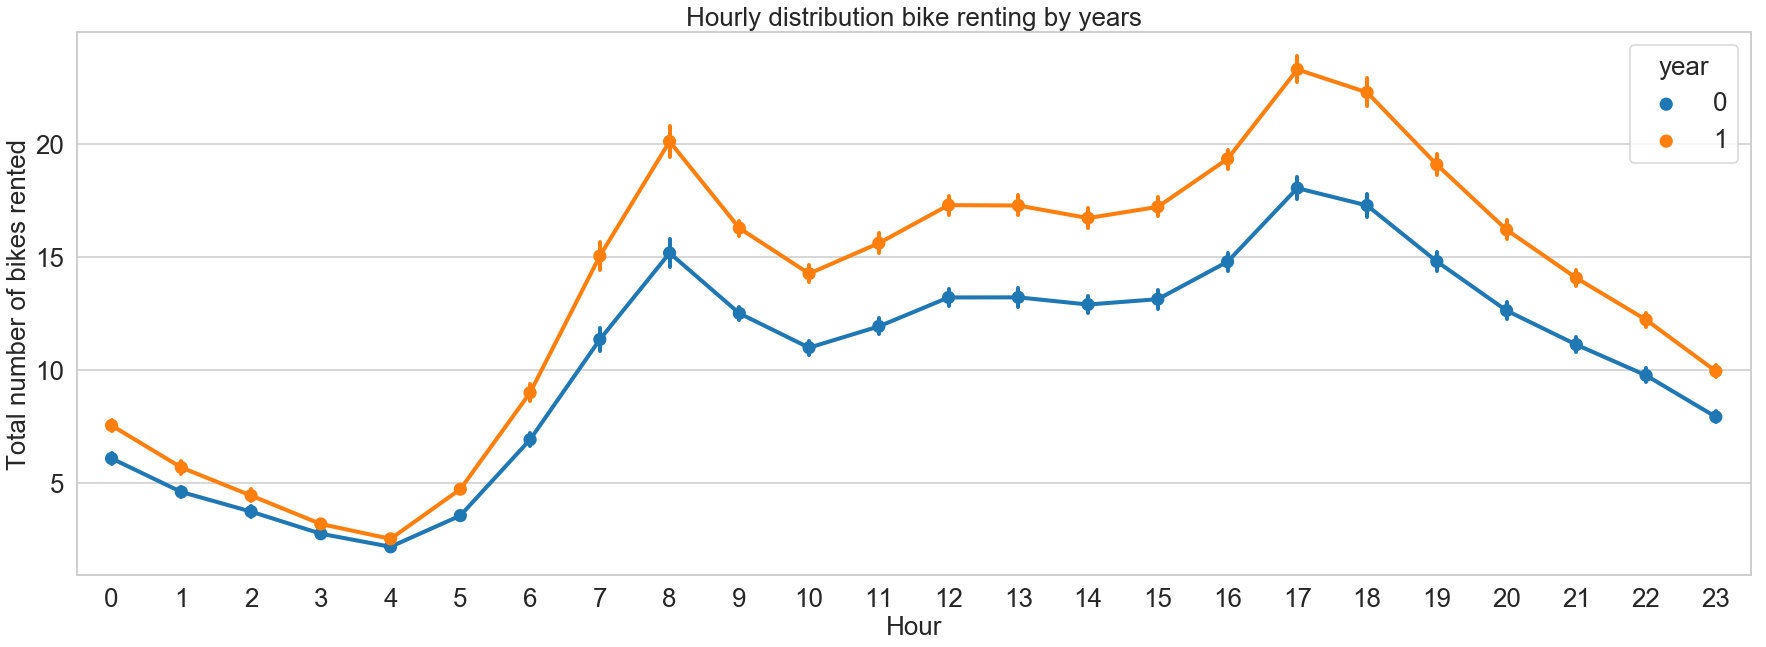

In [20]:
fig, ax = plt.subplots()
sns.pointplot(
    data=dataset_ddf[["hour", "count", "year"]].compute(),
    x="hour",
    y="count",
    hue="year",
    ax=ax,
)
plt.xlabel("Hour")
plt.ylabel("Total number of bikes rented")
ax.set(title="Hourly distribution bike renting by years")

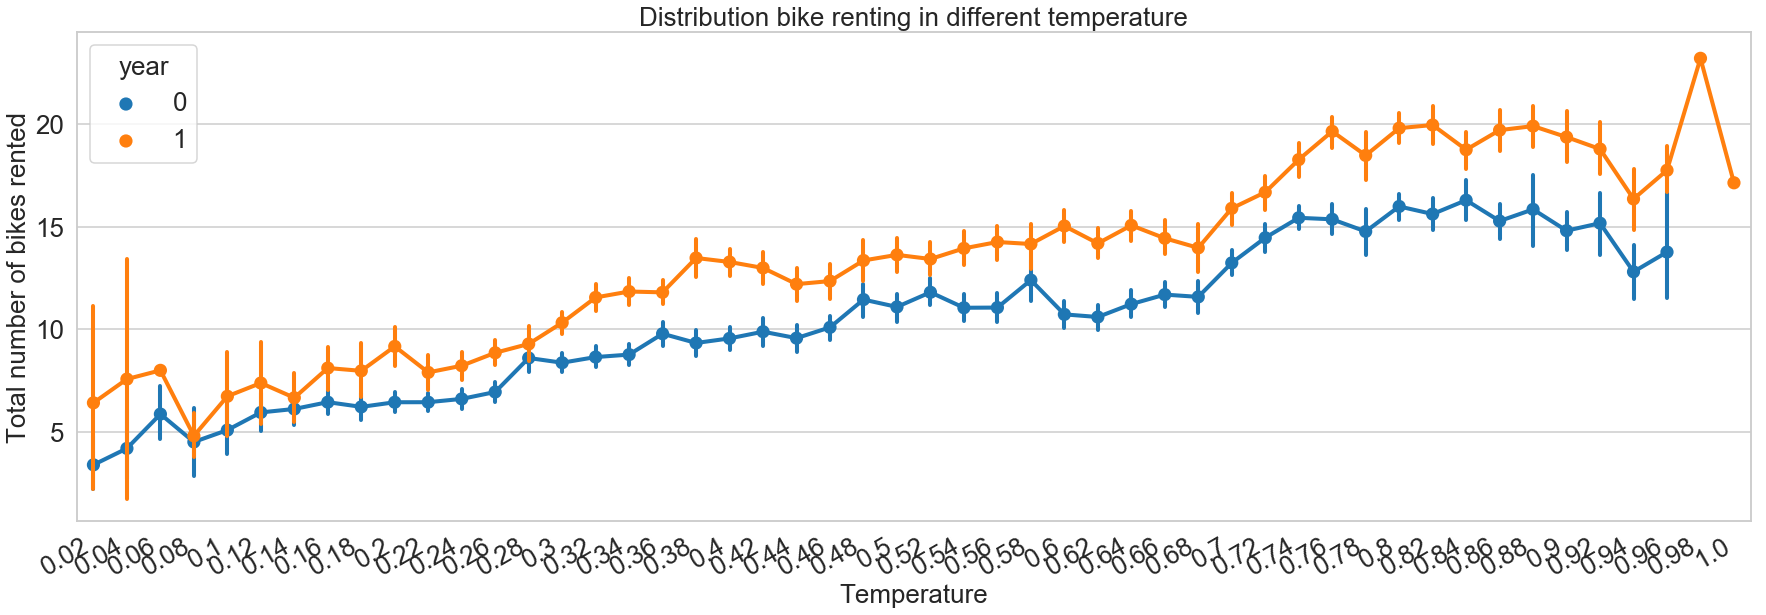

In [21]:
fig, ax = plt.subplots()
sns.pointplot(
    data=dataset_ddf[["temp", "count", "year"]].compute(),
    x="temp",
    y="count",
    hue="year",
    ax=ax,
)
plt.xlabel("Temperature")
plt.ylabel("Total number of bikes rented")
ax.set(title="Distribution bike renting in different temperature")
plt.gcf().autofmt_xdate()

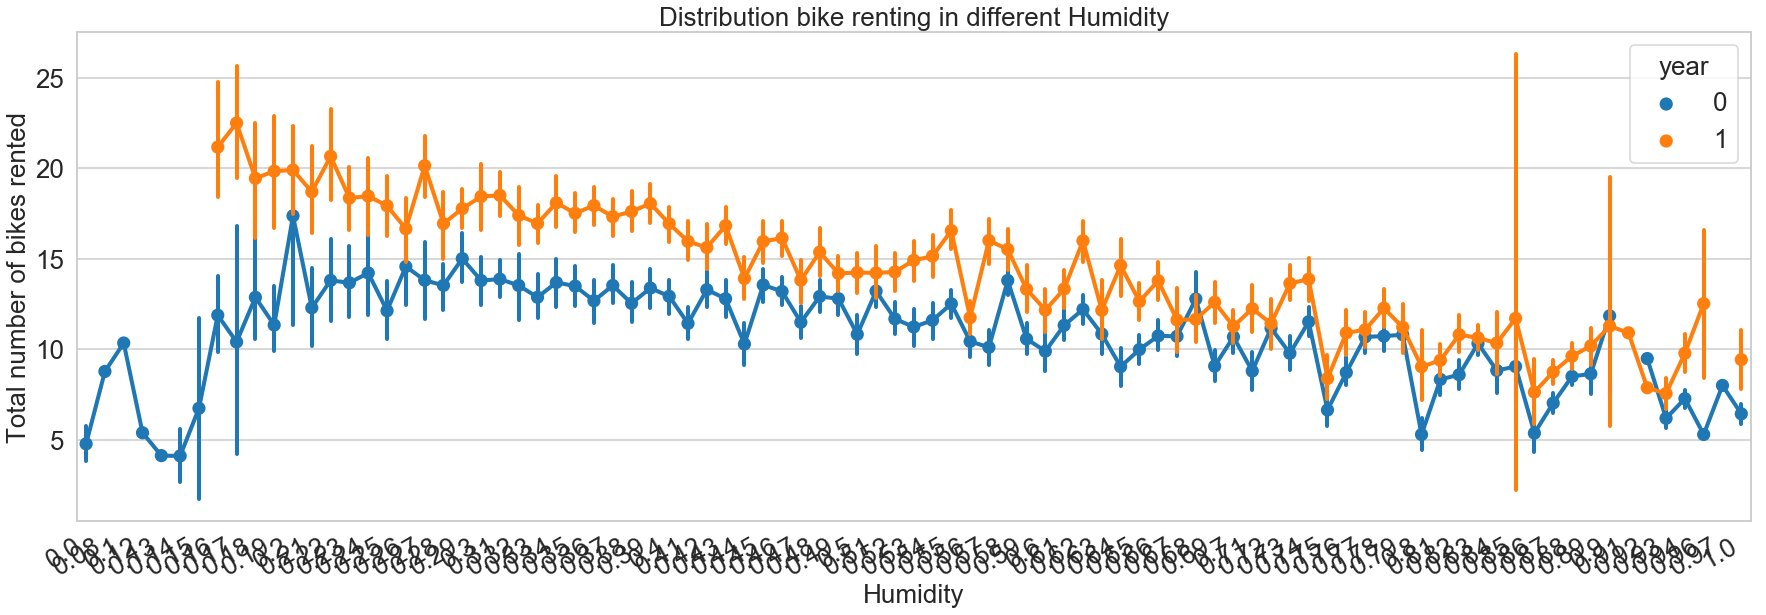

In [22]:
fig, ax = plt.subplots()
sns.pointplot(
    data=dataset_ddf[["hum", "count", "year"]].compute(),
    x="hum",
    y="count",
    hue="year",
    ax=ax,
)
plt.xlabel("Humidity")
plt.ylabel("Total number of bikes rented")
ax.set(title="Distribution bike renting in different Humidity")
plt.gcf().autofmt_xdate()

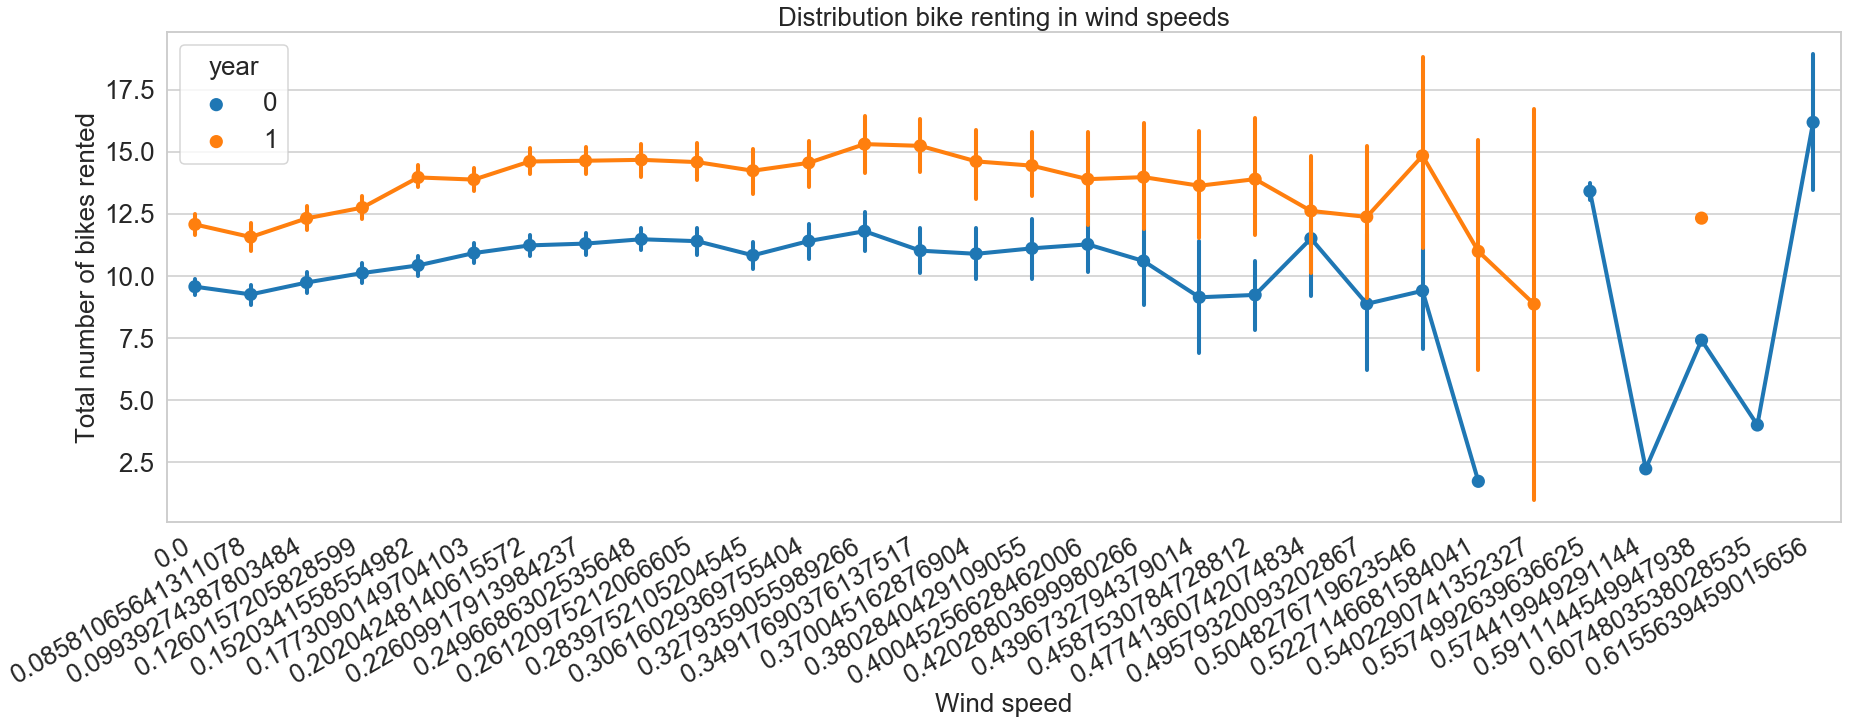

In [23]:
fig, ax = plt.subplots()
sns.pointplot(
    data=dataset_ddf[["windspeed", "count", "year"]].compute(),
    x="windspeed",
    y="count",
    hue="year",
    ax=ax,
)
plt.xlabel("Wind speed")
plt.ylabel("Total number of bikes rented")
ax.set(title="Distribution bike renting in wind speeds")
plt.gcf().autofmt_xdate()

# <font color='blue'>11. Remove outliers from the dataset</font>

We will now focus on numerical values. If `NAs` are the natural enemy of categorical values, the main problem with numerical values are outliers (values which largely differ from the rest). Outliers can mislead the training of our models resulting in less accurate models and ultimately worse results.

In this section we seek to identify outliers to then properly deal with them. If we summarize the dataset, we can see variables which "Max." is much larger than the rest of values. These features are susceptible of containing outliers. Nevetheless, the easiest way to detect outliers is visualizing the numerical values; for instance, by `boxploting` the column values.

In [24]:
# Let's find out the TRAINING dataset
test_index = (dataset_ddf.year == 1) & (
    (dataset_ddf.month == 10) | (dataset_ddf.month == 11) | (dataset_ddf.month == 12)
)

dataset_ddf_test = dataset_ddf[test_index]
dataset_ddf_train = dataset_ddf[~test_index]

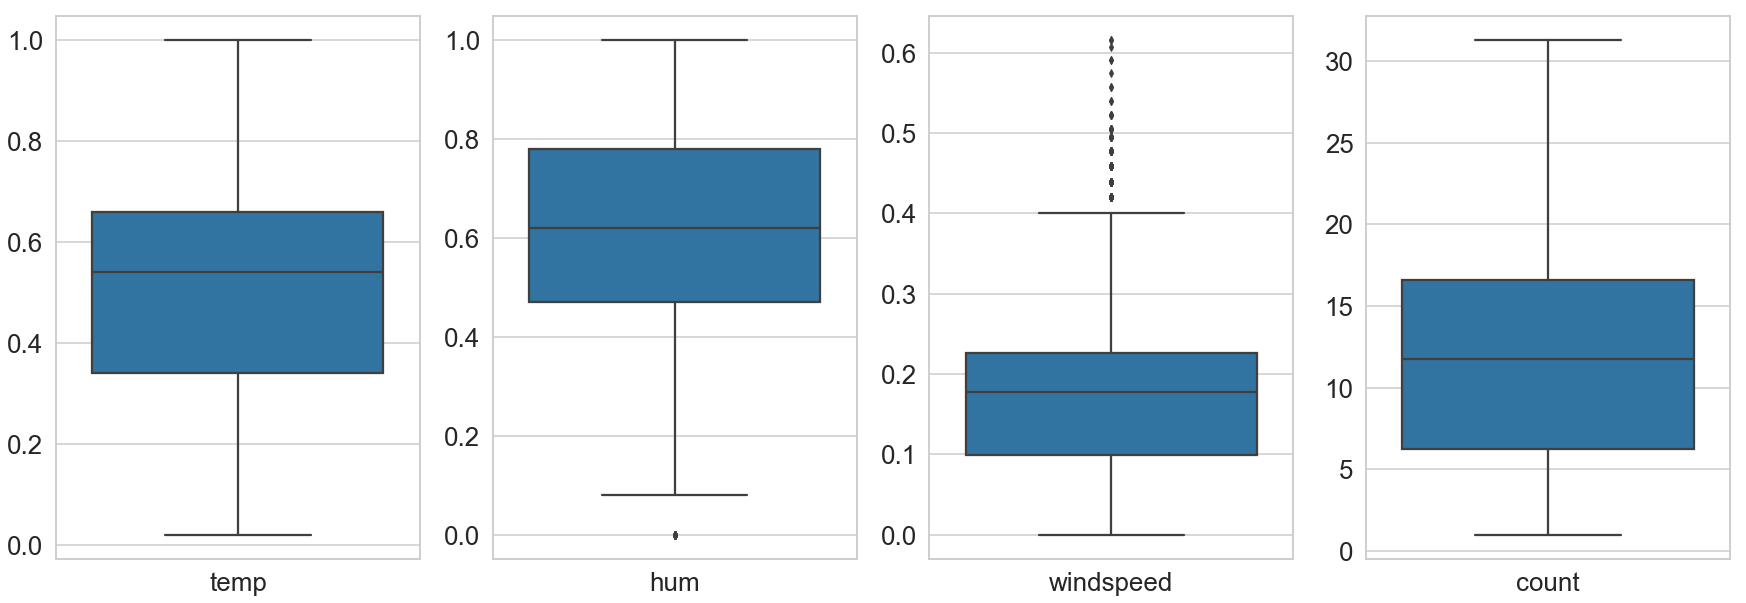

In [25]:
# Let's first check outliers using Box-plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)

sns.boxplot(data=dataset_ddf_train[["temp"]].compute(), ax=ax1)
sns.boxplot(data=dataset_ddf_train[["hum"]].compute(), ax=ax2)
sns.boxplot(data=dataset_ddf_train[["windspeed"]].compute(), ax=ax3)
sns.boxplot(data=dataset_ddf_train[["count"]].compute(), ax=ax4)

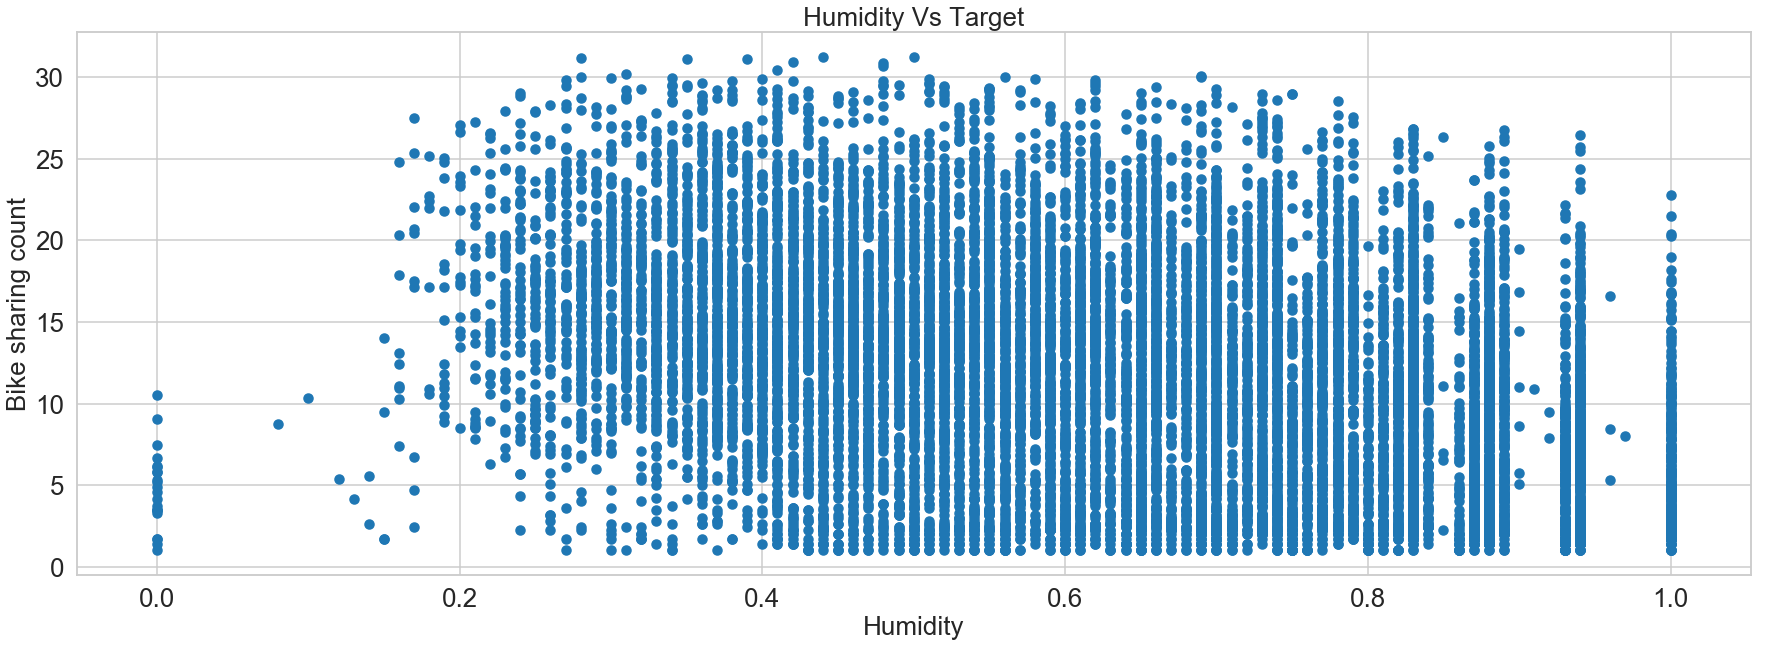

In [26]:
# Humidity vs Target
fig, ax = plt.subplots()
ax.scatter(
    dataset_ddf_train[["hum"]].compute(), dataset_ddf_train[["count"]].compute()
)
plt.title("Humidity Vs Target")
ax.set_xlabel("Humidity")
ax.set_ylabel("Bike sharing count")
fig.show()

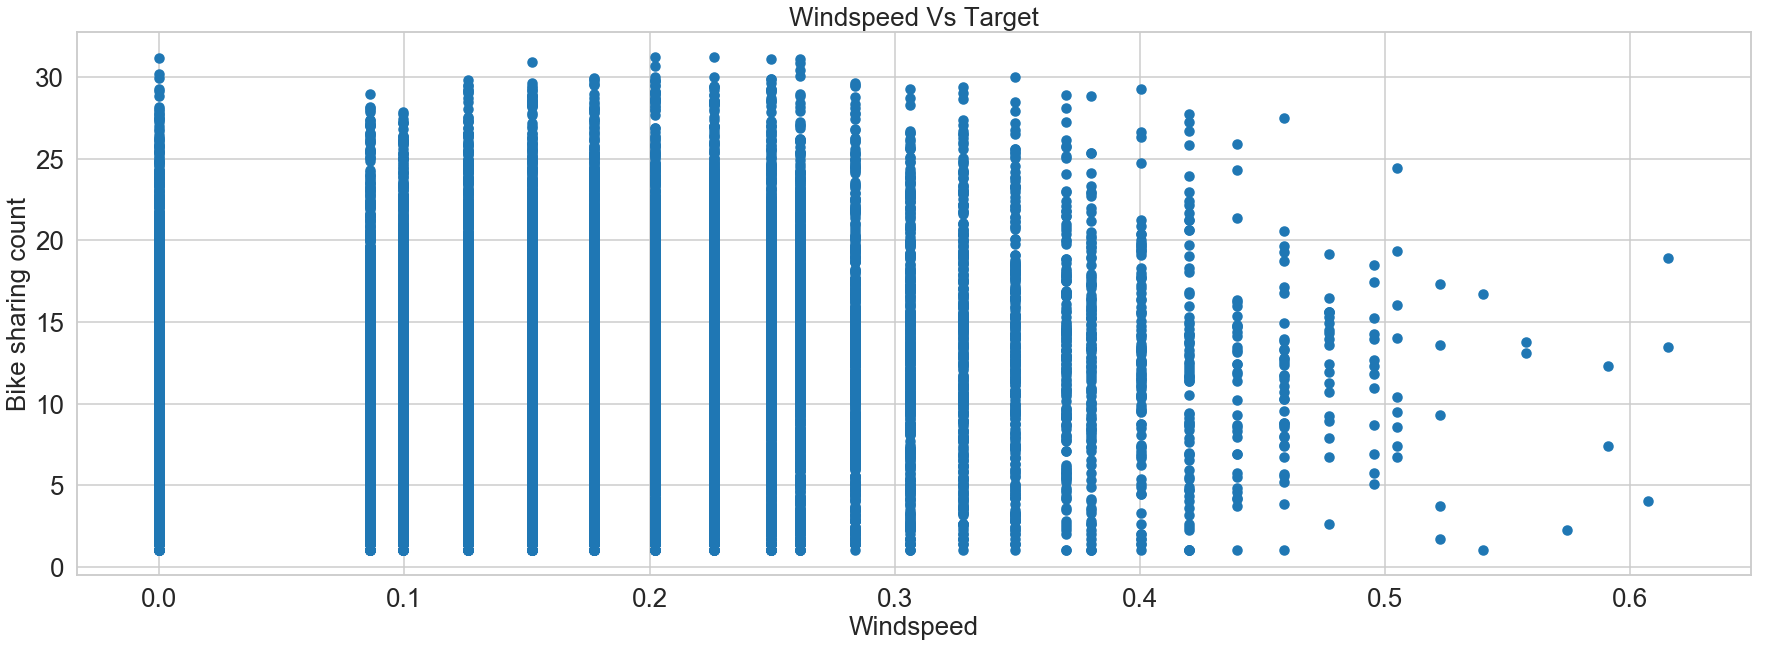

In [27]:
# Windspeed vs Target
fig, ax = plt.subplots()
ax.scatter(dataset_ddf_train[["windspeed"]].compute(), dataset_ddf_train[["count"]].compute())
plt.title("Windspeed Vs Target")
ax.set_xlabel("Windspeed")
ax.set_ylabel("Bike sharing count")
fig.show()

In [28]:
# Remove outliers from Trainset Windspeed (outside IQR)
q1_windspeed = dataset_ddf_train["windspeed"].compute().quantile(0.25)
q3_windspeed = dataset_ddf_train["windspeed"].compute().quantile(0.75)
iqr_windspeed = q3_windspeed - q1_windspeed

q1_hum = dataset_ddf_train["hum"].compute().quantile(0.25)
q3_hum = dataset_ddf_train["hum"].compute().quantile(0.75)
iqr_hum = q3_hum - q1_hum

dataset_ddf_train_1 = dataset_ddf_train[
    ~(
        (dataset_ddf_train["windspeed"] < (q1_windspeed - iqr_windspeed))
        | (dataset_ddf_train["windspeed"] > (q3_windspeed + iqr_windspeed))
        | (dataset_ddf_train["hum"] < (q3_hum - iqr_hum))
        | (dataset_ddf_train["hum"] > (q3_hum + iqr_hum))
    )
]

In [29]:
# Merge Train and Test
dataset_ddf = dd.concat(
    [dataset_ddf_train_1, dataset_ddf_test], interleave_partitions=True
)

# <font color='blue'>12. Hot Encoding/Dummification</font>

In [30]:
dummy_encoder = DummyEncoder()
dataset_ddf_encoded = dummy_encoder.fit_transform(dataset_ddf.categorize())

dataset_ddf_encoded.head()

,date,temp,hum,windspeed,count,season_1,season_2,season_3,season_4,year_0,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4
instant,,,,,,,,,,,,,,,,,,,,,
1,2011-01-01,0.24,0.81,0.0,4.000000,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
2,2011-01-01,0.22,0.80,0.0,6.324555,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
3,2011-01-01,0.22,0.80,0.0,5.656854,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
4,2011-01-01,0.24,0.75,0.0,3.605551,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
5,2011-01-01,0.24,0.75,0.0,1.000000,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0


# <font color='blue'>13. Model Creation</font>

In [31]:
# Train-Test split
test_index = (dataset_ddf_encoded.year_1 == 1) & (
    (dataset_ddf_encoded.month_10 == 1)
    | (dataset_ddf_encoded.month_11 == 1)
    | (dataset_ddf_encoded.month_12 == 1)
)

dataset_ddf_encoded_test = dataset_ddf_encoded[test_index]
dataset_ddf_encoded_train = dataset_ddf_encoded[~test_index]

# Let's separate the Targer and the features
y_train = dataset_ddf_encoded_train[["count"]]
x_train = dataset_ddf_encoded_train.drop(["count", "date"], 1)

y_test = dataset_ddf_encoded_test[["count"]]
x_test = dataset_ddf_encoded_test.drop(["count", "date"], 1)

# <font color='blue'>13.1. Linear Regression</font>

In [ ]:
# Create a LR model and fit the data
lr = LinearRegression()
lr.fit(x_train.values, y_train.values)

In [ ]:
# Predict for the Test data
y_test_lr_pred = lr.predict(x_test.values)

In [ ]:
# Calculate the R2 score
r2_score(y_test.values.compute(), y_test_lr_pred.compute())

# <font color='blue'>13.2. XG Boost</font>

In [32]:
# Create a XGB model
xgbr = xgb.XGBRegressor()

parameters = {'xgbr__max_depth': (5, 10, 15, 20),
              'xgbr__learning_rate': (0.01, 0.1),
              'xgbr__n_estimators': (50, 100, 150, 200),
             }

xgbr_cv= GridSearchCV(estimator=xgbr, 
                     param_grid=parameters, 
                     cv=3, 
                     verbose=1,
                     n_jobs=-1)

In [33]:
# Create a client
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:52690 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 8.50 GB


In [34]:
# Fit the model with the training data
with parallel_backend('dask'):
    xgbr_cv.fit(x_train.compute(), y_train.compute())

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.5min finished


In [35]:
# Best Parameters
xgbr_cv.best_params_

{'xgbr__learning_rate': 0.01, 'xgbr__max_depth': 5, 'xgbr__n_estimators': 50}

In [36]:
# Create a XGB model
xgb = XGBRegressor(learning_rate = 0.01, max_depth = 5, n_estimators = 50)
xgb.fit(x_train.values, y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [37]:
# Predict for the Test data
y_test_xgb_pred = xgb.predict(x_test.values)